In [19]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.interpolate import RegularGridInterpolator

import OpenAEM

Flow conditions (all quantities normalized by half-height and bulk velocity)

In [2]:
Re_tau = 800.0
n_hierarchies = 4

U_b = 1.0
h  = 1.0

Re_b = 0.5*(2*Re_tau/np.sqrt(0.0365))**(1/0.875) # Dean's relation Cf=0.073Rem^-0.25
print(f'Reynolds number based on bulk velocity and half height is {Re_b:5.1f}')
nu = U_b*h/Re_b
print(f'Kinematic viscosity nu is {nu:15.6e}')
lnu = h/Re_tau
print(f'Viscous length scale lnu is {lnu:15.7f}')
utau = nu/lnu
print(f'Viscous velocity scale is {utau:15.7f}')

Reynolds number based on bulk velocity and half height is 15218.4
Kinematic viscosity nu is    6.571003e-05
Viscous length scale lnu is       0.0012500
Viscous velocity scale is       0.0525680


Sampling volume

In [3]:
target_dxp = 30.0
print(f'Target resolution in viscous scale is {target_dxp:5.2f}')

Lx = 2.0
Ly = 2.0
Lz = 1.2

xmin = -Lx/2; xmax = Lx/2
ymin = -Ly/2; ymax = Ly/2
zmin = 0.0; zmax = Lz

nx = int(np.ceil(Lx/lnu/target_dxp))
ny = int(np.ceil(Ly/lnu/target_dxp))
nz = int(np.ceil(Lz/lnu/target_dxp))
print(f'The domain is discretized by {nx}, {ny} and {nz} cells in streamwise, spanwise and wall-normal direction, respectively')

dx = Lx/nx; dy = Ly/ny; dz = Lz/nz
print(f'The actual resolution is dx+ = {dx/lnu:5.2f}, dy+ = {dy/lnu:5.2f} and dz+ = {dz/lnu:5.2f}')

x = xmin + 0.5*dx + np.arange(nx)*dx
y = ymin + 0.5*dy + np.arange(ny)*dy
z = zmin + 0.5*dz + np.arange(nz)*dz

Target resolution in viscous scale is 30.00
The domain is discretized by 54, 54 and 32 cells in streamwise, spanwise and wall-normal direction, respectively
The actual resolution is dx+ = 29.63, dy+ = 29.63 and dz+ = 30.00


Hierarchy height

In [4]:
kline_scale = 100.0
eddy_heights = np.array([kline_scale*2**i for i in range(n_hierarchies)])
eddy_heights *= lnu
print(f'We have {n_hierarchies} hierarchies with heights') # delta in literature
for h in eddy_heights:
    print(h)

We have 4 hierarchies with heights
0.125
0.25
0.5
1.0


Eddies

In [5]:
packet = OpenAEM.pi_packet()
packet_mirror = OpenAEM.mirror_eddy(packet)

Let's get started with an eddy in the first hierarchy located at (0.2, 0.2, 0)

In [16]:
delta = eddy_heights[2]
xc = 0.2
yc = 0.2

# velocity at a plane near y = yc (0.2)
j_loc = np.argmin(np.abs(y - yc))

In [ ]:
U_true = np.zeros((nx, nz))
V_true = np.zeros_like(U_true)
W_true = np.zeros_like(U_true)

xr = (x - xc)/delta
yr = (y[j_loc] - yc)/delta
zr = z/delta

for i in range(nx):
    for k in range(nz):
        pt = np.array([xr[i], yr, zr[k]])
        uv = np.zeros(3)
        for curve in packet:
            uv += OpenAEM.biot_savart(pt, curve)
            
        for curve in packet_mirror:
            uv += OpenAEM.biot_savart(pt, curve)
            
        U_true[i, k] = uv[0]; V_true[i, k] = uv[1]; W_true[i, k]= uv[2]

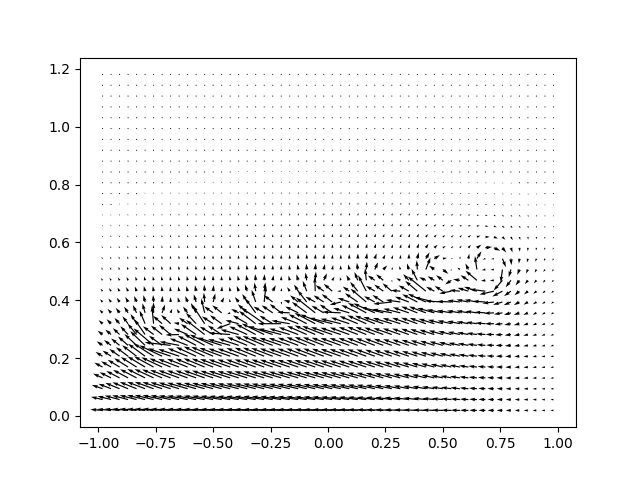

In [17]:
plt.figure()
X, Z = np.meshgrid(x, z, indexing='ij')
plt.quiver(X, Z, U_true, W_true)

In [21]:
nx_ext = int(np.ceil(2*Lx/dx)) + 1
ny_ext = int(np.ceil(2*Ly/dy)) + 1
nz_ext = nz + 1
x_ext = np.linspace(-Lx, Lx, nx_ext)
y_ext = np.linspace(-Ly, Ly, ny_ext)
z_ext = np.linspace(0, Lz, nz_ext)

U_ext = np.zeros((nx_ext, ny_ext, nz_ext))
W_ext = np.zeros_like(U_ext)

xr_ext = x_ext/delta
yr_ext = y_ext/delta
zr_ext = z_ext/delta

for i in range(nx_ext):
    for j in range(ny_ext):
        for k in range(nz_ext):
            pt = np.array([xr_ext[i], yr_ext[j], zr_ext[k]])
            uv = np.zeros(3)
            for curve in packet:
                uv += OpenAEM.biot_savart(pt, curve)
            
            for curve in packet_mirror:
                uv += OpenAEM.biot_savart(pt, curve)
            
            U_ext[i, j, k] = uv[0]; W_ext[i, j, k] = uv[2]

In [35]:
U_interpolator = RegularGridInterpolator((x_ext, y_ext, z_ext), U_ext, method='cubic')
W_interpolator = RegularGridInterpolator((x_ext, y_ext, z_ext), W_ext, method='cubic')

In [36]:
X, Y, Z = np.meshgrid(x - xc, y - yc, z, indexing='ij')
interpolated_U = U_interpolator((X, Y, Z))
interpolated_W = W_interpolator((X, Y, Z))

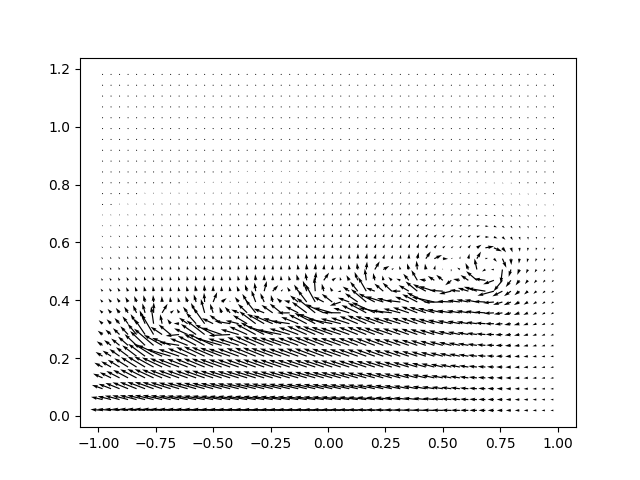

In [37]:
plt.figure()
X, Z = np.meshgrid(x, z, indexing='ij')
plt.quiver(X, Z, interpolated_U[:, j_loc, :], interpolated_W[:, j_loc, :])

In [38]:
fuck_U = interpolated_U[:, j_loc, :]

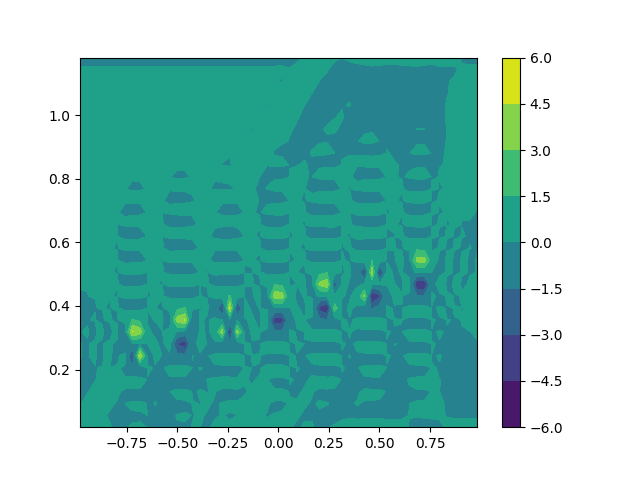

In [39]:
plt.figure()
plt.contourf(X, Z, fuck_U - U_true)
plt.colorbar()

In [42]:
fuck_U.max()

5.539712432384753

In [41]:
U_true.max()

4.319791855926078